# Portfolio Generator
Uses the implementation in the `.py` files to generate portfolios

In [1]:
import pandas as pd
import yfinance as yf

import analyst
import MVO
import utils

## Initialize Data

In [2]:
# CONSTANTS: TICKERS
NASDAQ_100 = open('data/nasdaq100.txt', 'r').read().split('\n')
DOW_JONES_30 = open('data/dj30.txt', 'r').read().split('\n')

NSDQ_INDEX = '^NDX'
DJ_INDEX = '^DJI'

In [3]:
# CONSTANTS: DATE
HIST_START = '2000-01-01'
HIST_END = '2024-01-01'

TEST_START = '2000-01-01'
TEST_END = '2023-06-01'

In [4]:
# CONSTANTS: DATA
MARKET_FF_HIST = pd.read_csv('data/ff_daily.csv')

NSDQ100_HIST = yf.download(NASDAQ_100, start = HIST_START, end = HIST_END, auto_adjust=True)
DJ30_HIST = yf.download(DOW_JONES_30, start = HIST_START, end = HIST_END, auto_adjust=True)

NSDQ_INDEX_HIST = yf.download([NSDQ_INDEX], start = HIST_START, end = HIST_END, auto_adjust=True)
DJ_INDEX_HIST = yf.download([DJ_INDEX], start = HIST_START, end = HIST_END, auto_adjust=True)

[*********************100%%**********************]  101 of 101 completed
[*********************100%%**********************]  30 of 30 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
# CONSTANTS: ANALYST DATA
RATINGS = pd.read_parquet('data/analyst_ratings.parquet')
GLOBAL_HIST = pd.read_parquet('data/hist_price.parquet')
PRICE_TARGET_HIST = pd.read_parquet('data/price_targets.parquet')

## Testing on Data

In [6]:
analysts = analyst.Analyst(RATINGS, GLOBAL_HIST)

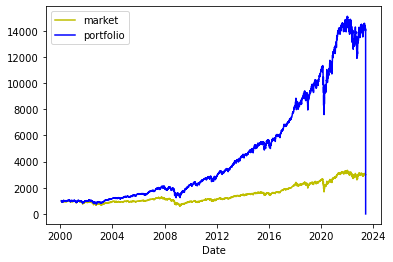

In [7]:
plot = utils.MVOPlot(MVO.Portfolio(DJ30_HIST, MARKET_FF_HIST, utils.dateadd(TEST_START, "m", 1), TEST_END),
                     MVO.Portfolio(DJ_INDEX_HIST, MARKET_FF_HIST, utils.dateadd(TEST_START, "m", 1), TEST_END))
# Ensure no look ahead bias
lagged_weights = None
for (s,e) in utils.daterange(TEST_START, TEST_END, interval="m"):
  risk_free_reference = MVO.Market(MARKET_FF_HIST, s, e)
  portfolio = MVO.Portfolio(DJ30_HIST, MARKET_FF_HIST, s, e)
  rankings = analysts.rank(e)
  price_target = analyst.PriceTarget(PRICE_TARGET_HIST, rankings, DOW_JONES_30)
  exp_ret = price_target.get_views(portfolio, e)
  mvo = MVO.MVO(portfolio, expected_returns=exp_ret)
  mvo.minimum_variance()
  if lagged_weights is not None:
    plot.add_returns(s, e, lagged_weights)
  lagged_weights = mvo.stats['Weights']
plot.plot()